## Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary as summary_

from tqdm.auto import tqdm

import albumentations as A # fast image agumentation library
from albumentations.pytorch.transforms import ToTensorV2 # 이미지 형 변환
import torchvision.models as models
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

file_path = '/content/drive/MyDrive/DACON/2022 관광데이터 AI 경진대회/data'

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [ ]:
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [ ]:
all_df = pd.read_csv(file_path + '/train.csv')

In [ ]:
all_df['img_path'] = file_path + all_df['img_path'].str[1:]

In [ ]:
train_df, val_df, _, _ = train_test_split(all_df, all_df['cat3'], test_size=0.2, random_state=CFG['SEED'])

## Label-Encoding

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(train_df['cat3'].values)

LabelEncoder()

In [ ]:
train_df['cat3'] = le.transform(train_df['cat3'].values)
val_df['cat3'] = le.transform(val_df['cat3'].values)

## Vectorizer

In [ ]:
vectorizer = CountVectorizer(max_features=4096)
# overview를 vectorize하는 vectorizer 선언, 최대 특성 수는 4096

In [ ]:
train_vectors = vectorizer.fit_transform(train_df['overview'])
train_vectors = train_vectors.todense()

val_vectors = vectorizer.transform(val_df['overview'])
val_vectors = val_vectors.todense()

In [ ]:
train_vectors.shape

(13588, 4096)

In [ ]:
val_vectors.shape

(3398, 4096)

## CustomDataset

In [ ]:
# Dataset 생성
class CustomDataset(Dataset):
    def __init__(self, img_path_list, text_vectors, label_list, transforms, infer=False):
        self.img_path_list = img_path_list
        self.text_vectors = text_vectors
        self.label_list = label_list
        self.transforms = transforms
        self.infer = infer
        
    def __getitem__(self, index):
        # NLP
        text_vector = self.text_vectors[index]
        
        # Image 읽기
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image'] # transforms(=image augmentation) 적용
        
        # Label
        if self.infer: # infer == True, test_data로부터 label "결과 추출" 시 사용
            return image, torch.Tensor(text_vector).view(-1)
        else: # infer == False
            label = self.label_list[index] # dataframe에서 label 가져와 "학습" 시 사용
            return image, torch.Tensor(text_vector).view(-1), label
        
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

albumentations -> fast image augmentation library

albumentations.Compose -> transform = A.Compose([])을 이용하여 이미지와 라벨 각각에 Augmentation을 적용하기 위한 객체를 생성

albumentations.Resize(128, 128) -> 128*128 size로 resize

albumentations.Normalize() -> 입력 받은 이미지 값의 범위를 (0, 255) → (-1, 1) 범위로 줄여주는 역할, 위에서는 평균값, 분산값, 최대 픽셀값으로 img = (img - mean * max_pixel_value) / (std * max_pixel_value)을 계산.

ToTensorV2 -> tensor형 변환

In [ ]:
train_dataset = CustomDataset(train_df['img_path'].values, train_vectors, train_df['cat3'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(val_df['img_path'].values, val_vectors, val_df['cat3'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

- DataLoader: Dataset와 Sampler를 결합하고 지정된 데이터 세트에 대해 반복 가능한 기능을 제공.
1. dataset (Dataset): 데이터를 로드할 데이터 집합.
2. batch_size (int, optional): how many samples per batch to load (default: 1).
3. num_workers (int, optional): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0) -> 6으로 설정 시 안돌아감([Errno 32] Broken pipe). 0으로 변경해야 됨

## Model Define

In [ ]:
from torch.nn.modules import conv
class CustomModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(CustomModel, self).__init__()
        # Image
        self.cnn_extract = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                # input_channel = 3 : RGB 3개의 채널이기 때문
                # out_channel = 8 : 출력하는 채널 8개
                # stride = 1 : stride 만큼 이미지 이동하면서 cnn 수행
                # padding = 1 : zero-padding할 사이즈
            nn.ReLU(), # 사용할 활성화 함수: Relu를 사용
            # nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2), # 최댓값을 뽑아내는 맥스 풀링
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        summary_(self.cnn_extract, (3,256,256), batch_size = 64)
        # Text
        self.nlp_extract = nn.Sequential(
            nn.Linear(4096, 2048), # 선형회귀. 4096개의 입력으로 2048개의 출력
            nn.ReLU(),
            nn.Linear(2048, 1024), # 선형회귀. 2048개의 입력으로 1024개의 출력
        )
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(4160, num_classes)
            # 선형회귀. 4160개의 입력으로 num_classes, 즉 cat3의 종류 개수만큼의 출력
            # 근데 왜 4160개? "4160 - 1024 = 3136"이고 "3136 / 64 = 49". 즉 이미지는 "7*7*64"로 출력됨.
        )
            

    def forward(self, img, text):
        img_feature = self.cnn_extract(img) # cnn_extract 적용
        img_feature = torch.flatten(img_feature, start_dim=1) # 1차원으로 변환
        text_feature = self.nlp_extract(text) # nlp_extract 적용
        feature = torch.cat([img_feature, text_feature], axis=1) # 2개 연결(3136 + 1024)
        output = self.classifier(feature) # classifier 적용
        return output

## Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device) # gpu(cpu)에 적용

    criterion = nn.CrossEntropyLoss().to(device) # CrossEntropyLoss: 다중분류를 위한 손실함수
    best_score = 0
    best_model = None # 최고의 모델을 추출하기 위한 파라미터
    train_loss_list = []
    val_loss_list = []
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train() # 학습시킴.
        train_loss = []
        for img, text, label in tqdm(iter(train_loader)): # train_loader에서 img, text, label 가져옴
            img = img.float().to(device)
            text = text.to(device)
            label = label.type(torch.LongTensor) # label type을 LongTensor로 형변환, 추가하여 에러 해결
            label = label.to(device)
            
            optimizer.zero_grad() # 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭하는 걸 방지, 0으로 초기화

            model_pred = model(img, text) # 예측
            
            loss = criterion(model_pred, label) # 예측값과 실제값과의 손실 계산

            loss.backward() # .backward() 를 호출하면 역전파가 시작
            optimizer.step() # optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정

            train_loss.append(loss.item())
            
        # 모든 train_loss 가져옴
        tr_loss = np.mean(train_loss)
            
        val_loss, val_score = validation(model, criterion, val_loader, device) # 검증 시작, 여기서 validation 함수 사용
            
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        train_loss_list.append(tr_loss)
        val_loss_list.append(val_loss)
        if scheduler is not None:
            scheduler.step()
            # scheduler의 의미: Learning Rate Scheduler => learning rate를 조절한다. 
            # DACON에서는 CosineAnnealingLR 또는 CosineAnnealingWarmRestarts 를 주로 사용한다.
            
        if best_score < val_score: # 최고의 val_score을 가진 모델에 대해서만 최종적용을 시킴
            best_score = val_score
            best_model = model
    
    plt.figure(figsize = (10,7))
    plt.plot([i for i in range(1,11)], train_loss_list, color = 'b', label = 'train_loss')
    plt.plot([i for i in range(1,11)], val_loss_list, color = 'r', label = 'val_loss')
    plt.legend()
    plt.show()
    
    return best_model # val_score가 가장 높은 모델을 출력

In [ ]:
def score_function(real, pred):
    return f1_score(real, pred, average="weighted")

def validation(model, criterion, val_loader, device):
    model.eval() # nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    
    model_preds = [] # 예측값
    true_labels = [] # 실제값
    
    val_loss = []
    
    with torch.no_grad():
        for img, text, label in tqdm(iter(val_loader)): # val_loader에서 img, text, label 가져옴
            img = img.float().to(device)
            text = text.to(device)
            label = label.type(torch.LongTensor) # label type을 LongTensor로 형변환, 추가하여 에러 해결
            label = label.to(device)
            
            model_pred = model(img, text)
            
            loss = criterion(model_pred, label) # 예측값, 실제값으로 손실함수 적용 -> loss 추출
            
            val_loss.append(loss.item()) # loss 출력, val_loss에 저장
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
        
    test_weighted_f1 = score_function(true_labels, model_preds) # 실제 라벨값들과 예측한 라벨값들에 대해 f1 점수 계산
    return np.mean(val_loss), test_weighted_f1 # 각각 val_loss, val_score에 적용됨

## Run!!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 8, 256, 256]             224
              ReLU-2          [64, 8, 256, 256]               0
           Dropout-3          [64, 8, 256, 256]               0
         MaxPool2d-4          [64, 8, 128, 128]               0
            Conv2d-5         [64, 16, 128, 128]           1,168
              ReLU-6         [64, 16, 128, 128]               0
           Dropout-7         [64, 16, 128, 128]               0
         MaxPool2d-8           [64, 16, 64, 64]               0
            Conv2d-9           [64, 32, 64, 64]           4,640
             ReLU-10           [64, 32, 64, 64]               0
          Dropout-11           [64, 32, 64, 64]               0
        MaxPool2d-12           [64, 32, 32, 32]               0
           Conv2d-13           [64, 64, 31, 31]          32,832
             ReLU-14           [64, 64,

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [1], Train Loss : [3.08380] Val Loss : [2.73036] Val Score : [0.36404]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.98571] Val Loss : [2.23562] Val Score : [0.47375]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [3], Train Loss : [1.45926] Val Loss : [2.04355] Val Score : [0.53364]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [4], Train Loss : [1.13016] Val Loss : [1.95308] Val Score : [0.55148]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.88269] Val Loss : [1.98646] Val Score : [0.55968]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.67586] Val Loss : [2.02279] Val Score : [0.56797]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.50563] Val Loss : [2.10944] Val Score : [0.57195]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.35704] Val Loss : [2.22020] Val Score : [0.57296]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.24089] Val Loss : [2.38650] Val Score : [0.57014]


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.15591] Val Loss : [2.51729] Val Score : [0.57084]


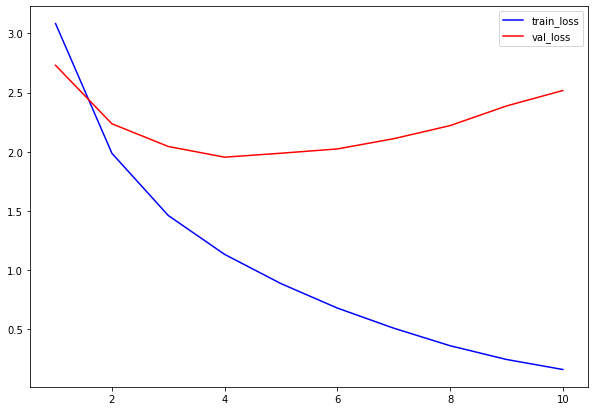

In [ ]:
model = CustomModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

## Inference

In [ ]:
test_df = pd.read_csv(file_path + '/test.csv')
test_df['img_path'] = file_path + test_df['img_path'].str[1:]
test_vectors = vectorizer.transform(test_df['overview'])
test_vectors = test_vectors.todense()

In [ ]:
test_dataset = CustomDataset(test_df['img_path'].values, test_vectors, None, test_transform, True)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [ ]:
def inference(model, test_loader, deivce):
    model.to(device)
    model.eval()
    
    model_preds = []
    
    with torch.no_grad():
        for img, text in tqdm(iter(test_loader)):
            img = img.float().to(device)
            text = text.to(device)
            
            model_pred = model(img, text)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
    # img, text에 따른 예측값들을 model_preds 배열에 넣어 리턴
    return model_preds

In [ ]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/114 [00:00<?, ?it/s]

## Submission

In [ ]:
submit = pd.read_csv(file_path + '/sample_submission.csv')

In [ ]:
submit['cat3'] = le.inverse_transform(preds)

In [ ]:
submit.to_csv(file_path + '/submit_0927_1.csv', index=False)